In [19]:
import torch
from torch import nn
from diffusers import StableDiffusionPipeline
import transformers
from peft import LoraConfig, get_peft_model
import re
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import os, glob
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd
import re
from pathlib import PurePosixPath
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# DATA LOADING AND PREPROCESSING

In [20]:
drive.mount('/content/drive', force_remount=True)

# Adjust these paths to match your folder structure
DATA_ARCHIVE_DIR = "/content/drive/MyDrive/csc413-chexpert"  # shared folder
DATA_LABELS_DIR = "/content/drive/MyDrive/train+valid"
LOCAL_DATA_ROOT  = "/content/chexpert_data"                  # local SSD on VM


Mounted at /content/drive


If `chexpert_data` is courupted use the following code to delete it:

In [23]:
"""
LOCAL_DATA_ROOT = "x/content/chexpert_data"

# # Delete any partial extraction
!rm -rf "{LOCAL_DATA_ROOT}"

import os
os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)
"""

In [42]:
!apt-get -y install unrar > /dev/null

rar_files = sorted(glob.glob(os.path.join(DATA_ARCHIVE_DIR, "*.rar")))
print(f"Found {len(rar_files)} RAR files in shared folder")

for r in tqdm(rar_files, desc="Extracting RAR archives"):
    !unrar x -y -idq "{r}" "{LOCAL_DATA_ROOT}/" > /dev/null 2>&1

Found 4 RAR files in shared folder


Extracting RAR archives:   0%|          | 0/4 [00:00<?, ?it/s]

In [44]:
!rsync -a --info=progress2 "{DATA_LABELS_DIR}/" "{LOCAL_DATA_ROOT}/"

     23,196,953 100%   32.30MB/s    0:00:00 (xfr#2, to-chk=0/3)


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
LOCAL_DATA_ROOT = "/content/chexpert_data"  # where you unrar’d

# quick sanity check
dirs = !find "{LOCAL_DATA_ROOT}" -maxdepth 2 -type d | head -n 20
dirs


['/content/chexpert_data',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23440',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23441',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23442',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23443',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23444',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23445',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23446',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23447',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23448',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23449',
 '/content/chexpert_data/CheXpert-v1.0-train2-512px-letterboxed/patient23450',
 '/content/chexpert_data/CheXpert-v1.0

In [50]:
# collect all JPG/PNG images under LOCAL_DATA_ROOT
image_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    image_paths.extend(
        glob.glob(os.path.join(LOCAL_DATA_ROOT, "**", ext), recursive=True)
    )

print("Total images:", len(image_paths))

def parse_path(p):
    p = Path(p)
    # .../CheXpert-v1.0-train1-512px-letterboxed/patientXXXX/studyY/view1_frontal.jpg
    patient_id = p.parents[2].name   # 'patient00001'
    study_id   = p.parents[1].name   # 'study1'
    view_name  = p.stem              # 'view1_frontal'
    return patient_id, study_id, view_name

records = []
for path in image_paths:
    patient_id, study_id, view_name = parse_path(path)
    records.append(
        {
            "image_path": path,
            "patient_id": patient_id,
            "study_id": study_id,
            "view": view_name,
        }
    )

df = pd.DataFrame.from_records(records)
df.head()


Total images: 223648


,image_path,patient_id,study_id,view
0,/content/chexpert_data/CheXpert-v1.0-train2-51...,CheXpert-v1.0-train2-512px-letterboxed,patient25997,view1_frontal
1,/content/chexpert_data/CheXpert-v1.0-train2-51...,CheXpert-v1.0-train2-512px-letterboxed,patient25997,view1_frontal
2,/content/chexpert_data/CheXpert-v1.0-train2-51...,CheXpert-v1.0-train2-512px-letterboxed,patient25997,view1_frontal
3,/content/chexpert_data/CheXpert-v1.0-train2-51...,CheXpert-v1.0-train2-512px-letterboxed,patient25997,view1_frontal
4,/content/chexpert_data/CheXpert-v1.0-train2-51...,CheXpert-v1.0-train2-512px-letterboxed,patient25997,view1_frontal


In [52]:
# TODO: these files need to be added manually for now, but we will automate soon
# point these at wherever the CSVs are in your extracted folder
TRAIN_CSV = os.path.join(LOCAL_DATA_ROOT, "train.csv")
VALID_CSV = os.path.join(LOCAL_DATA_ROOT, "valid.csv")

train_labels = pd.read_csv(TRAIN_CSV)
valid_labels = pd.read_csv(VALID_CSV)

def parse_label_path(s):
    p = PurePosixPath(str(s).replace("\\", "/"))
    return p.parts[-3], p.parts[-2], p.stem  # patientXXXX, studyY, view stem

for lab_df in (train_labels, valid_labels):
    parsed = lab_df["Path"].apply(parse_label_path)
    lab_df["patient_id"] = parsed.apply(lambda t: t[0])
    lab_df["study_id"]   = parsed.apply(lambda t: t[1])
    lab_df["view"]       = parsed.apply(lambda t: t[2])

pat_re  = re.compile(r"patient\d+$")
study_re = re.compile(r"study\d+$")

def parse_from_image_path(path_str: str):
    parts = PurePosixPath(str(path_str).replace("\\", "/")).parts

    # find .../patientXXXX/studyY/<file>
    for i in range(len(parts) - 2):
        if pat_re.fullmatch(parts[i]) and study_re.fullmatch(parts[i+1]):
            patient_id = parts[i]
            study_id   = parts[i+1]
            view       = PurePosixPath(parts[i+2]).stem
            return patient_id, study_id, view

    # fallback (rare)
    return parts[-3], parts[-2], PurePosixPath(parts[-1]).stem

parsed = df["image_path"].apply(parse_from_image_path)
df["patient_id"] = parsed.apply(lambda t: t[0])
df["study_id"]   = parsed.apply(lambda t: t[1])
df["view"]       = parsed.apply(lambda t: t[2])

In [53]:
LABEL_COLS = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity",
    "Lung Lesion", "Edema", "Consolidation", "Pneumonia", "Atelectasis",
    "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture",
    "Support Devices"
]

train_tab = df.merge(train_labels[["patient_id","study_id","view"] + LABEL_COLS],
                     on=["patient_id","study_id","view"], how="inner")

valid_tab = df.merge(valid_labels[["patient_id","study_id","view"] + LABEL_COLS],
                     on=["patient_id","study_id","view"], how="inner")

def y_dx_to_prompts(y_dx):
    # y_dx: (B,14) tensor with tokens {0 blank, 1 neg, 2 pos, 3 uncertain}
    prompts = []
    for row in y_dx.detach().cpu().tolist():
        parts = []
        for name, tok in zip(LABEL_COLS, row):
            if tok == 0:
                continue
            elif tok == 1:
                parts.append(f"{name}: negative")
            elif tok == 2:
                parts.append(f"{name}: positive")
            elif tok == 3:
                parts.append(f"{name}: uncertain")
        prompts.append(", ".join(parts) if parts else "No Finding")
    return prompts

Splint into train, validate and test sets:

In [54]:
# Use provided valid.csv as TEST
PERCENT_DATA_TO_USE = 1 - 0.60
test_split = valid_tab.reset_index(drop=True)

# Create our own VAL split from the training table (patient-level split)
gss = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
train_idx, val_idx = next(gss.split(train_tab, groups=train_tab["patient_id"]))

train_split = train_tab.iloc[train_idx].reset_index(drop=True)
val_split   = train_tab.iloc[val_idx].reset_index(drop=True)


gss_small = GroupShuffleSplit(n_splits=1, test_size=PERCENT_DATA_TO_USE, random_state=123)
small_idx, _ = next(gss_small.split(train_split, groups=train_split["patient_id"]))
train_split_small = train_split.iloc[small_idx].reset_index(drop=True)

print("small train:", len(train_split_small), "of", len(train_split))
print("train/val/test:", len(train_split), len(val_split), len(test_split))
print("unique patients:", train_split["patient_id"].nunique(),
      val_split["patient_id"].nunique(),
      test_split["patient_id"].nunique())

small train: 2091 of 201035
train/val/test: 201035 22379 234
unique patients: 58086 6454 200


This function maps CheXpert label to an integer code:

NaN -> 0 = “blank” / not mentioned in report

0 -> 1 = negative

1 -> 2 = positive

2 -> 3 = uncertain


In [55]:
def encode_label(v):
    if pd.isna(v): return 0
    if v == 0.0:     return 1
    if v == 1.0:     return 2
    if v == -1.0:    return 3
    return 0

for c in LABEL_COLS:
    train_split[c] = train_split[c].map(encode_label)
    val_split[c]   = val_split[c].map(encode_label)
    test_split[c]  = test_split[c].map(encode_label)
    train_split_small[c] = train_split_small[c].map(encode_label)

In [56]:
train_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("L").convert("RGB")),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

eval_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("L").convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [57]:
class CheXpertDataset(Dataset):
    def __init__(self, tab, label_cols, transform):
        self.tab = tab.reset_index(drop=True)
        self.label_cols = label_cols
        self.transform = transform

    def __len__(self): return len(self.tab)

    def __getitem__(self, idx):
        row = self.tab.iloc[idx]
        img = Image.open(row["image_path"])
        img = self.transform(img)
        y = self.tab[self.label_cols].iloc[idx].to_numpy(dtype="int64", copy=False)
        y_dx = torch.from_numpy(y)
        prompt = y_dx_to_prompts(torch.from_numpy(y[None, :]))[0]
        return {"pixel_values": img, "y_dx": y_dx, "prompts": prompt, "path": row["image_path"]}

train_ds = CheXpertDataset(train_split, LABEL_COLS, train_tf)
val_ds   = CheXpertDataset(val_split,   LABEL_COLS, eval_tf)
test_ds  = CheXpertDataset(test_split,  LABEL_COLS, eval_tf)
train_ds_small = CheXpertDataset(train_split_small, LABEL_COLS, train_tf)

train_loader_small = DataLoader(train_ds_small, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

In [58]:
# 4) one-batch sanity check
b = next(iter(train_loader))
print("pixel:", b["pixel_values"].shape, b["pixel_values"].dtype,
      float(b["pixel_values"].min()), float(b["pixel_values"].max()))
print("labels:", b["y_dx"].shape, b["y_dx"].dtype, torch.unique(b["y_dx"]))
print(np.unique(train_split[LABEL_COLS].to_numpy()))

pixel: torch.Size([8, 3, 512, 512]) torch.float32 -1.0 1.0
labels: torch.Size([8, 14]) torch.int64 tensor([0, 1, 2])
[0 1 2 3]


## LOADING THE MODEL AND ADDING LORA


In [59]:
model_id = "sd-legacy/stable-diffusion-v1-5"
# For GPU use, pipe = pipe.to('cuda')
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

transformer_weights_str_pattern_lora = re.compile(r"(attn1|attn2)\.(to_q|to_k|to_v|to_out\.0)\.(weight|bias)$")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [60]:
# Access U-Net Parameters
count = 0
for name, param in pipe.unet.named_parameters():
    param.requires_grad = False # freezes layer
    if transformer_weights_str_pattern_lora.search(name):
        #print(name, param.shape)
        count += param.numel()

# 160 layers 93536640 trainable parameters.
print("Number of LoRA trainable parameters: {}".format(count))

Number of LoRA trainable parameters: 93536640


In [61]:
# Access Variational Autoencder (VAE) params
for name, param in pipe.vae.named_parameters():
    param.requires_grad = False # freeze layers

# Access Text Encoder params
for name, param in pipe.text_encoder.named_parameters():
    param.requires_grad = False # freeze layers

In [62]:
# LoRA config
lora_config = LoraConfig(
    r=1, # Low-rank dimension
    lora_alpha=16, # Scaling
    target_modules=['to_q', 'to_k', 'to_v', 'to_out.0'],
    lora_dropout=0.05,
    bias='none'
)

# Apply LoRA to U-Net
pipe.unet = get_peft_model(pipe.unet, lora_config)

In [63]:
finetune_params = 0
for name, param in pipe.unet.named_parameters():
    if param.requires_grad:
        #print(name, param.shape)
        finetune_params += param.numel()

# 797184 instead of 860M parameters
print(f"Total trainable parameters: {finetune_params}")

Total trainable parameters: 199296


## GENERATING FAKE DATA TO TEST


In [64]:
# --- 1. Define synthetic dataset ---
# class SyntheticDataset(Dataset):
#     def __init__(self, num_samples=10, image_size=(3, 64, 64)):
#         self.num_samples = num_samples
#         self.image_size = image_size
#         # Generate random "prompts" as short strings
#         self.prompts = [f"A synthetic image {i}" for i in range(num_samples)]

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         # Random image in [-1, 1] like SD expects
#         image = torch.randn(*self.image_size)
#         prompt = self.prompts[idx]
#         return image, prompt

# # --- 2. Create DataLoader ---
# dataset = SyntheticDataset(num_samples=5, image_size=(3, 64, 64))
# dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

## INITIAL TEST GENERATING AN IMAGE

  0%|          | 0/30 [00:00<?, ?it/s]

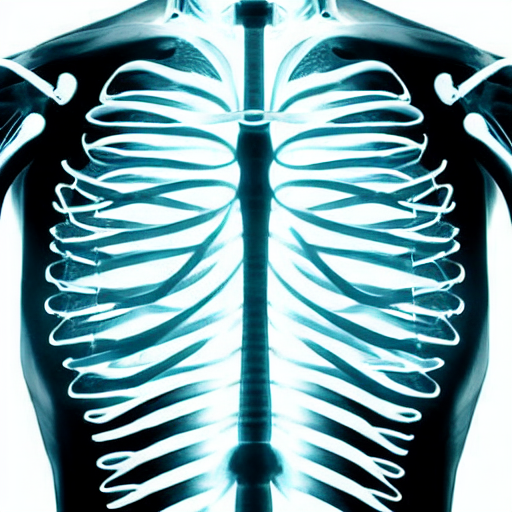

In [84]:
# INITIAL TEST GENERATING AN IMAGE

# 4. Define a test prompt based on your fine-tuning data/style
test_prompt = "A high resolution XRay with the following - Lung Opacity: positive, Edema: positive, Pneumonia: uncertain, Support Devices: positive"
# 5. Run inference to generate the test image
pipe_test = pipe.to("cuda")
generator = torch.Generator("cuda").manual_seed(42)
test_image = pipe_test(
    test_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=generator
).images[0]

# 6. Display the image
display(test_image) # Requires running in a Colab/Jupyter notebook environment

## TRAINING LOOP

In [66]:
## Separate Components from Pipeline
device = torch.device("cuda")
vae = pipe.vae.to(device)
unet = pipe.unet.to(device)
text_encoder = pipe.text_encoder.to(device) # change from float to half precision for GPU
tokenizer = pipe.tokenizer
noise_scheduler = pipe.scheduler

In [67]:
# freese the VAE and text encoder, but leave the unet for training

# change to train_loader for full set, train_loader_small is 1% of train data
TRAINING_SET = train_loader_small

vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.train()

optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-5)

pbar = tqdm(TRAINING_SET, desc="Train", total=len(TRAINING_SET))

for step, batch in enumerate(pbar):
    # Clear CUDA cache at the start of each iteration to free up any unallocated memory
    # Primary fix is to reduce batch_size in DataLoader (e.g., in cell mbz0wc30_6yv)
    torch.cuda.empty_cache()

    images = batch["pixel_values"].to(device=device, dtype=vae.dtype)
    y_dx   = batch["y_dx"].to(device)
    prompts = batch["prompts"]

    # 1. latents
    latents = vae.encode(images).latent_dist.sample()
    latents = latents * 0.18215

    # 2. timesteps
    t = torch.randint(0, noise_scheduler.num_train_timesteps, (latents.size(0),), device=latents.device, dtype=torch.long)

    # 3. noise + noisy latents
    noise = torch.randn_like(latents)
    noisy_latents = noise_scheduler.add_noise(latents, noise, t)

    # 4. text embeddings
    input_ids = tokenizer(prompts, padding="max_length", truncation=True, max_length=tokenizer.model_max_length, return_tensors="pt").input_ids
    input_ids = input_ids.to(device)
    text_embeds = text_encoder(input_ids)[0]

    # 5. UNet predicts noise
    noise_pred = unet(noisy_latents, t, encoder_hidden_states=text_embeds).sample

    # 6. loss
    loss = F.mse_loss(noise_pred, noise)

    # 7. optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_postfix(loss=float(loss.item()))

Train:   0%|          | 0/262 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'PNDMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'PNDMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [68]:
# MAKE SURE TO CHANGE THE FOLDER NAME BEFORE EACH RUN!!!!!

# Create the path string
output_dir = "/content/drive/MyDrive/lora_weights/my_project_v1"

# Create the folder (if it doesn't exist)
import os
os.makedirs(output_dir, exist_ok=True)

# Save the weights
pipe.unet.save_pretrained(output_dir, safe_serialization=True)
print(f"LoRA weights successfully saved to: {output_dir}")

LoRA weights successfully saved to: /content/drive/MyDrive/lora_weights/my_project_v1


# FINAL TEST GENERATING AN IMAGE


In [69]:
# Loading the weights back to the unet from saved

from peft import PeftModel


weights_dir = "/content/drive/MyDrive/lora_weights/my_project_v1"

pipe.unet = PeftModel.from_pretrained(
    pipe.unet,          # The base model component to attach to
    weights_dir,          # The path to your saved LoRA weights
    is_trainable=False  # Set to False for inference
)

print(f"LoRA weights loaded onto pipe.unet using PeftModel.")

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


LoRA weights loaded onto pipe.unet using PeftModel.


/usr/local/lib/python3.12/dist-packages/peft/peft_model.py:598: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora_A.default.weight', 'base_model.model.base_model.model.

  0%|          | 0/30 [00:00<?, ?it/s]

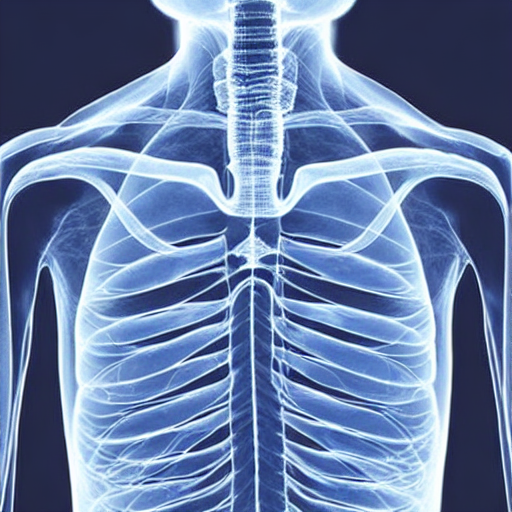

In [88]:
# TEST GENERATING AN IMAGE

# 4. Define a test prompt based on your fine-tuning data/style
test_prompt = "A high resolution XRay with the following - Lung Opacity: positive, Edema: positive, Pneumonia: uncertain, Support Devices: positive"

# 5. Run inference to generate the test image
pipe = pipe.to("cuda")
generator = torch.Generator("cuda").manual_seed(42) # 42
test_image = pipe(
    test_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=generator
).images[0]

# 6. Display the image
display(test_image) # Requires running in a Colab/Jupyter notebook environment

In [ ]:
# pipe.unet = unet --> update pipe